## About this notebook
This notebook has the experients done in **Uncovering differential equations from data with hidden variables** when some variables of the system are not observed. We analyze the oscilator, Rossler and Lorenz Attractor system when only one variable is observed. 


In [1]:
import numpy as np
import sys
import os
import warnings

In [2]:
notebooks_dir = get_ipython().starting_dir
sys.path.append(os.path.join(notebooks_dir, '..', '.'))

In [3]:
from src.scripts.ode.generate_data import generate_data
from src.lib.simulation_manager import Oscilator, LorenzAttractor, RoselerAttractor
from src.scripts.ode.fit_odefind import fit_and_save_coeffs
from src.scripts.config import data_path, results_path
from src.scripts.ode.integrate_predict import integrate_predict_smape
from src.scripts.ode.plot_predictions import plot_predictions , plot_times

## Generate data

In [4]:
gen_data = [['LorenzAttractor', LorenzAttractor,[{'sigma': 10, 'rho': 28, 'beta': 8.0 / 3}]],
            ['rosseler', RoselerAttractor,[{'a': 0.52, 'b': 2, 'c': 4}]],
            ['oscilator',Oscilator,[{'a': 0.1, 'b': -1, 'c': 1, 'd': 0}] ]
           ]
for data_experiment_name, model_class, list_model_parms in gen_data:
    
    folder_data = generate_data(
                    num_experiments_per_param=20,
                    num_time_steps=5000,
                    dt=0.01,

                    data_experiment_name=data_experiment_name,
                    model_class=model_class,
                    list_model_params=list_model_parms
                )
    print(f'Data was saved in {folder_data}')

Data was saved in /home/yamila/projects/rte2020/L-ODEfind/examples/../data/LorenzAttractor
Data was saved in /home/yamila/projects/rte2020/L-ODEfind/examples/../data/rosseler
Data was saved in /home/yamila/projects/rte2020/L-ODEfind/examples/../data/oscilator


## Experiments setting
Select the system.

In [5]:
# # Rossler with x as observed variable
# system = 'rosseler'
# obs_vars = ['x']
# targets = [2,3]
# maxpolys = [3]
# targets_to_plot = targets

In [6]:
# # Rossler with y as observed variable
# system = 'rosseler'
# obs_vars = ['y']
# targets = [2,3]
# maxpolys = [3]
# targets_to_plot = targets

In [7]:
# # Lorenz Attractor with x as observed variable
# system = 'LorenzAttractor'
# obs_vars = ['x']
# targets = [2,3]
# maxpolys = [3]
# targets_to_plot = targets

In [8]:
# Temperature data set
system = 'temperatures'
obs_vars = ['x']
targets = [2, 3]
maxpolys = [3]
targets_to_plot = targets

## Fit L-ODEfind models

In [9]:
%%time
model = system
out = system
warnings.filterwarnings("ignore")
fit_and_save_coeffs(model, out, targets=targets, maxpolys=maxpolys, obs_vars=obs_vars, testsize=200)


CPU times: user 8min 29s, sys: 7min 12s, total: 15min 41s
Wall time: 2min 9s


## Fit GPoMo models
We use R to fit GPoMo models. The library GPoM needs to be installed.

In [10]:
d_path = str(data_path.resolve()) + f'/{system}/'
r_path = str(results_path.resolve()) + f"/{system}_{'_'.join(obs_vars)}/"
v = '_'.join(obs_vars)

In [11]:
%%time
%cd ..
%cd r_scripts
! Rscript gpomo_predition_1_var_observed.R $d_path $r_path $v

/home/yamila/projects/rte2020/L-ODEfind
/home/yamila/projects/rte2020/L-ODEfind/r_scripts
Loading required package: GPoM
Loading required package: deSolve
Loading required package: rgl
[1] "/home/yamila/projects/rte2020/L-ODEfind/data/temperatures/"
[1] "/home/yamila/projects/rte2020/L-ODEfind/results/temperatures_x/"
[1] "x"
[1] "/home/yamila/projects/rte2020/L-ODEfind/data/temperatures/"
[1] "--------------------------"
[1] "solution_params_0_init_cond_103.csv"
[1] "--------------------------"
[1] "Doing steps: 40 max time derivative 2 poly degree 3"
### For Istep = 10 (max: 40), models to test: 10 / 10 
### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.1s  
### For Istep = 40 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.17s  
### Number of unclassified models: 10 / 10 
[1] "Time: 0.94511079788208"
[1] "Doing steps: 40 max time derivative 3 poly degree 3"
### For Istep = 10 (max: 40), models to test: 20 / 20 
### For Istep = 20 (max: 40), models 

### For Istep = 20 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.49s  
### For Istep = 40 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.73s  
### Number of unclassified models: 20 / 20 
[1] "Time: 3.60497379302979"
[1] "--------------------------"
[1] "solution_params_0_init_cond_168.csv"
[1] "--------------------------"
[1] "Doing steps: 40 max time derivative 2 poly degree 3"
### For Istep = 10 (max: 40), models to test: 10 / 10 
### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.1s  
### For Istep = 40 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.2s  
### Number of unclassified models: 10 / 10 
[1] "Time: 1.01382827758789"
[1] "Doing steps: 40 max time derivative 3 poly degree 3"
### For Istep = 10 (max: 40), models to test: 20 / 20 
### For Istep = 20 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.39s  
### For Istep = 40 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.76s  
### Number of unclassified mod

### Number of unclassified models: 20 / 20 
[1] "Time: 3.12934279441833"
[1] "--------------------------"
[1] "solution_params_0_init_cond_25.csv"
[1] "--------------------------"
[1] "Doing steps: 40 max time derivative 2 poly degree 3"
### For Istep = 10 (max: 40), models to test: 10 / 10 
### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.1s  
### For Istep = 40 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.2s  
### Number of unclassified models: 10 / 10 
[1] "Time: 1.02821469306946"
[1] "Doing steps: 40 max time derivative 3 poly degree 3"
### For Istep = 10 (max: 40), models to test: 20 / 20 
### For Istep = 20 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.37s  
### For Istep = 40 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.69s  
### Number of unclassified models: 20 / 20 
[1] "Time: 3.18923830986023"
[1] "--------------------------"
[1] "solution_params_0_init_cond_29.csv"
[1] "--------------------------"
[1] "Doing step

### For Istep = 10 (max: 40), models to test: 10 / 10 
### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.09s  
### For Istep = 40 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.17s  
### Number of unclassified models: 10 / 10 
[1] "Time: 0.887549638748169"
[1] "Doing steps: 40 max time derivative 3 poly degree 3"
### For Istep = 10 (max: 40), models to test: 20 / 20 
### For Istep = 20 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.35s  
### For Istep = 40 (max: 40), models to test: 20 / 20. Runtime: ~ 0h 0min 0.67s  
### Number of unclassified models: 20 / 20 
[1] "Time: 3.0135600566864"
[1] "--------------------------"
[1] "solution_params_0_init_cond_77.csv"
[1] "--------------------------"
[1] "Doing steps: 40 max time derivative 2 poly degree 3"
### For Istep = 10 (max: 40), models to test: 10 / 10 
### For Istep = 20 (max: 40), models to test: 10 / 10. Runtime: ~ 0h 0min 0.09s  
### For Istep = 40 (max: 40), models to test: 10 / 10. R

## Integrate, predict and compute SMAPE for L-ODEfind and GPoMo models

In [12]:
%%time
odefind_model = f"{system}_{'_'.join(obs_vars)}_Odefind"
gpomo_model = f"{system}_{'_'.join(obs_vars)}"
for model_data, model_results in [[system,gpomo_model],[system, odefind_model]]:
    df = integrate_predict_smape(original_data=model_data, results_folder=model_results,
                             time_horizons=np.arange(1, 200, dtype=int),
                             testsize=200, one=False, verbose=True)


solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_172-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_142-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_58-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_187-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_117-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_82-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_115-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_36-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_127-steps_40.csv
Doing fit and predictions
solution-gpomo_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_47-ste

solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_99-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_103-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_82-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_115-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_3-poly_3-params_0-init_cond_147-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_81-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_140-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_9-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_cond_72-steps_0.csv
Doing fit and predictions
solution-pdefind_coefs-vars_x-dmax_2-poly_3-params_0-init_con

## Plot predictions comparison

System:temperatures with observed variables ['x']


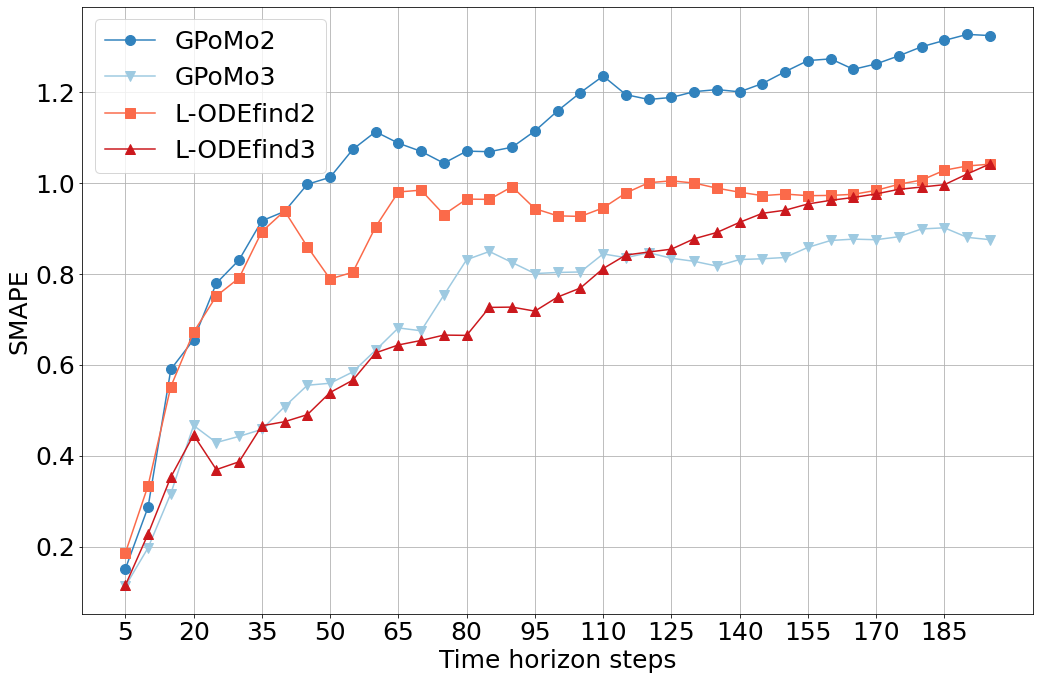

In [13]:
print(f'System:{system} with observed variables {obs_vars}')
plot_data = plot_predictions(path_gpomo = gpomo_model,
                             time_horizons = np.arange(5, 196, 5), 
                             path_pdefind = odefind_model, 
                             ymax = None, 
                             targets_to_plot = targets_to_plot)


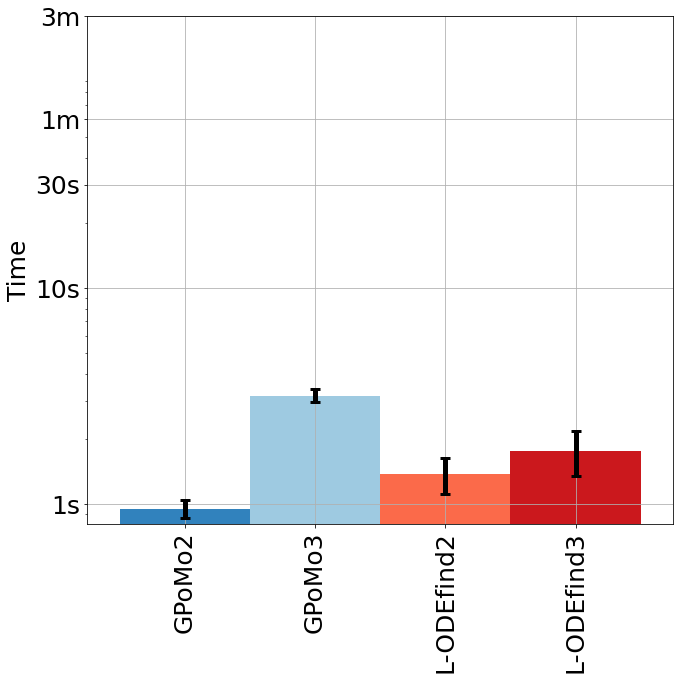

In [14]:
times_data = plot_times(gpomo_model, odefind_model,targets_to_plot=targets_to_plot)